In [449]:
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd

# Abertura do arquivo no formato NetCDF (Network Common Data Form)

In [450]:
# Diretório dos arquivos.
DIRETORIO_DADOS = '../input/precipitacao/CPC'

# Abertura do arquivo.
ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/precip.????.nc')

# Importação de variáveis.
prec = ds['precip']
lat = ds['lat']
lon = ds['lon']

In [451]:
prec

<xarray.DataArray 'precip' (time: 11688, lat: 31, lon: 22)>
dask.array<concatenate, shape=(11688, 31, 22), dtype=float32, chunksize=(366, 31, 22), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2022-12-31
  * lon      (lon) float32 315.2 315.8 316.2 316.8 ... 324.2 324.8 325.2 325.8
  * lat      (lat) float32 -2.25 -2.75 -3.25 -3.75 ... -16.25 -16.75 -17.25
Attributes:
    long_name:     Daily total of precipitation
    units:         mm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    cell_methods:  time: sum
    avg_period:    0000-00-01 00:00:00
    actual_range:  [  0.     970.5962]
    dataset:       CPC Global Precipitation

# Abertura do arquivo shapefile

In [452]:
# Nome do arquivo shapefile.
Nome_Arquivo_Shapefile = '../input/shapefile/caatinga_contorno/caatinga.shp'

# Leitura do arquivo shapefile.
arquivo_shp = gpd.read_file(Nome_Arquivo_Shapefile)

In [453]:
arquivo_shp

,gid,nome,shape_area,shape_len,geometry
0,1,Caatinga,67.971323,72.915234,"POLYGON ((-40.49531 -2.78574, -40.49173 -2.788..."


<AxesSubplot:>

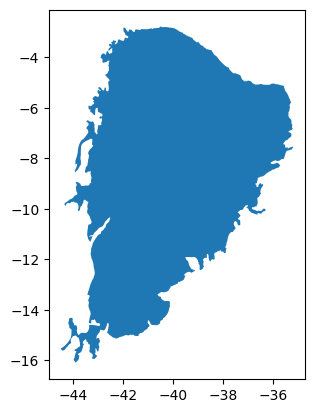

In [454]:
# Plot básico do arquivo shapefile.
arquivo_shp.plot()

# Criação da máscara para aplicar na variável de interesse

In [455]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.html

# Domínio espacial do arquivo shapefile.
dominio_shapefile = regionmask.Regions(
    outlines=arquivo_shp.geometry.values,
    numbers=[0],
    names={0:'Bioma Caatinga'},
    abbrevs={0:'Caatinga'},
    name='Bioma_Caatinga', 
)

dominio_shapefile

<regionmask.Regions 'Bioma_Caatinga'>
overlap:  False

Regions:
0 Caatinga Bioma Caatinga

[1 regions]

In [456]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.mask.html#regionmask.Regions.mask

# Cria a máscara que será aplicada na variável de interesse.
mascara = dominio_shapefile.mask(
    lon_or_obj=lon,
    lat=lat,
    lon_name='longitude',
    lat_name='latitutde',
)

/home/gui/anaconda3/envs/cbagro/lib/python3.9/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


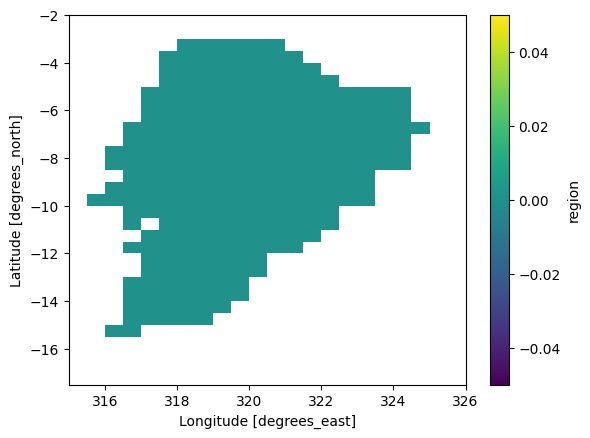

In [457]:
# Plot básico da máscara. NÃO É A VARIÁVEL A SER UTILIZADA!
mascara.plot()

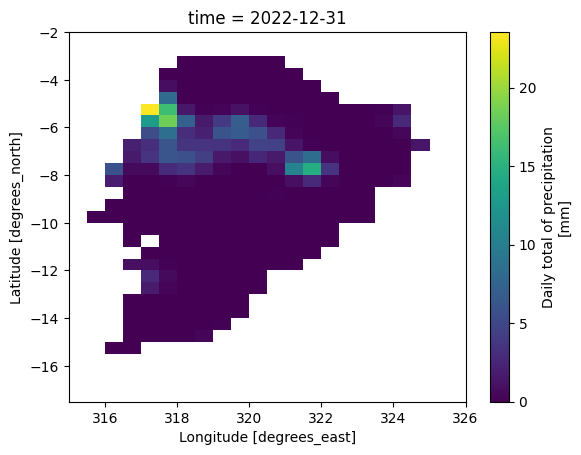

In [458]:
# Aplica a máscara na variável de interesse.
dado_mascarado = prec.where(mascara == mascara)

# Plot básico da variável mascarada. 

# Objetivo deste plot: apenas visualizar a variável mascarada 
# para ser se tudo está correto.

# Para a geração de um gráfico mais elaborado, utilizar a biblioteca Matplotlib
# ou outra do seu interesse.

# Plot do último tempo (data) do arquivo.
dado_mascarado[-1,:,:].plot()

# Cálculo da média espacial

É feita a média de todos os pontos de grade de latitude e de longitude. O resultado final é uma série temporal diária
do Bioma Caatinga.

In [459]:
# Os nomes 'lat' e 'lon fazem parte do seu arquivo.
media_area = dado_mascarado.mean(dim=('lat', 'lon'))

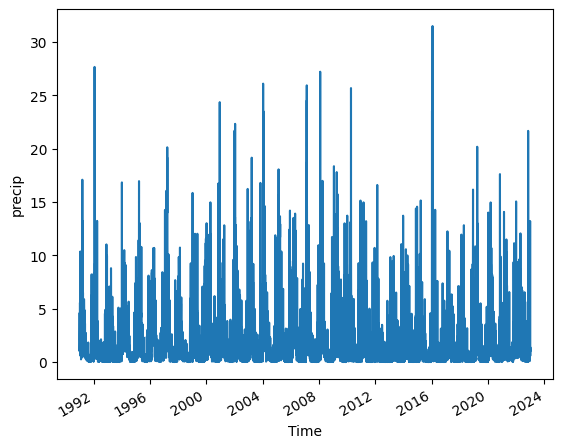

In [460]:
# Plot básico de todos os tempos (dias) da variável 'media_area'.
media_area.plot()

# Criação do DataFrame para armazenar a variável

Os **DataFrames** são objetos bidimensionais, de tamanho variável. 

O seu formato é de uma tabela, onde os dados são organizados em linhas e colunas. 

Além disso, enquanto podemos pensar a **Series** como uma única coluna, o DataFrame seria uma união de várias Series sob um mesmo index.

In [461]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

# Cria o DataFrame.
df1 = pd.DataFrame(data=media_area, index=prec.time, columns=['Chuva'])

# Define o nome do index como 'Dia'.
df1.index.name = 'Dia'

# Faz uma cópia do df1 para usar posterior.
df2 = df1.copy()

In [462]:
df1

,Chuva
Dia,
1991-01-01,1.083005
1991-01-02,1.132334
1991-01-03,1.101605
1991-01-04,1.662441
1991-01-05,1.765939
...,...
2022-12-27,0.583862
2022-12-28,0.579153
2022-12-29,1.396807


In [463]:
df1.describe()

,Chuva
count,11687.000000
mean,1.942385
std,2.798179
min,0.000000
25%,0.260504
50%,0.857347
75%,2.442850
max,31.495855


<AxesSubplot:xlabel='Dia'>

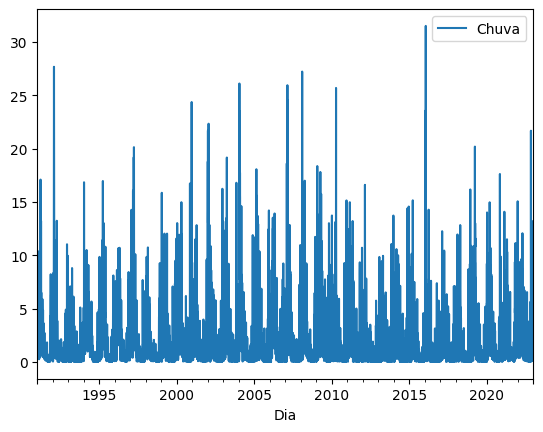

In [464]:
df1.plot()

# Algumas transformações no DataFrame

## Acumulado semanal de precipitação

In [465]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

# A semana começa no domingo.
# 1991-01-06 = domingo -> soma todos os dias 1, 2, 3, 4, 5 e 6 até domingo.
# 1991-01-13 = domingo -> soma todos os 7, 8, 9, 10, 11, 12 e 13.

acumulado_semanal = df1.resample('W').sum()

acumulado_semanal

,Chuva
Dia,
1991-01-06,9.129289
1991-01-13,21.347733
1991-01-20,34.693554
1991-01-27,30.552475
1991-02-03,12.096516
...,...
2022-12-04,41.211758
2022-12-11,11.958293
2022-12-18,17.074450


## Acumulado mensal

In [466]:
acumulado_mensal = df1.resample('MS').sum()

acumulado_mensal

,Chuva
Dia,
1991-01-01,100.099648
1991-02-01,79.893944
1991-03-01,164.202332
1991-04-01,71.712448
1991-05-01,56.974304
...,...
2022-08-01,35.391964
2022-09-01,14.892078
2022-10-01,16.885502


## Acumulado sazonal

In [467]:
acumulado_sazonal1 = df1.resample('QS-DEC').sum()

# Remove o dia do rótulo da série temporal.
acumulado_sazonal2 = acumulado_sazonal1.resample('M', kind='period').sum()

acumulado_sazonal2

,Chuva
Dia,
1990-12,179.993591
1991-01,0.000000
1991-02,0.000000
1991-03,292.889069
1991-04,0.000000
...,...
2022-08,0.000000
2022-09,153.571350
2022-10,0.000000


## Acumulado anual

<AxesSubplot:xlabel='Dia'>

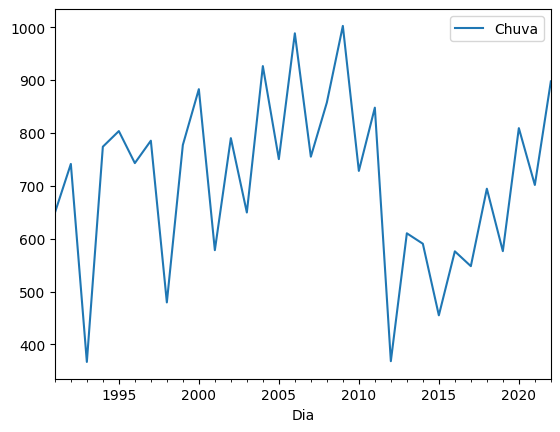

In [468]:
acumulado_anual1 = df1.resample('YS').sum()

# Remove o mês e o dia do rótulo da série temporal.
acumulado_anual2 = acumulado_anual1.resample('Y', kind='period').sum()

acumulado_anual2.plot()

## Média móvel

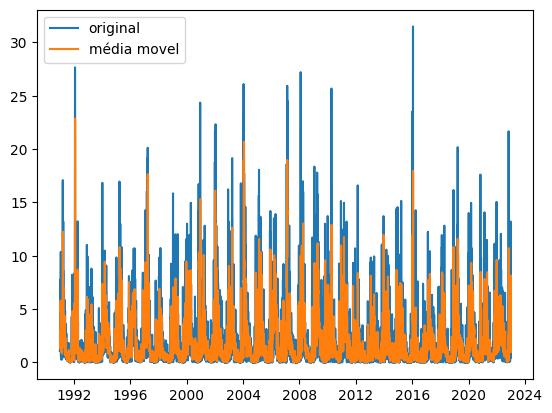

In [469]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

# Média móvel com janela deslizante.
media_movel1 = df1.rolling(window=5).mean()

import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel1, label='média movel')
plt.legend()

In [470]:
# Média móvel com resample. Janela temporal fixa. 
# Neste caso, calcula a média a cada 5 dias de dados.
media_movel2 = df1.resample('5D').mean()

media_movel2

,Chuva
Dia,
1991-01-01,1.349065
1991-01-06,2.798643
1991-01-11,4.138704
1991-01-16,4.747704
1991-01-21,5.576074
...,...
2022-12-09,1.191073
2022-12-14,3.208421
2022-12-19,2.969979


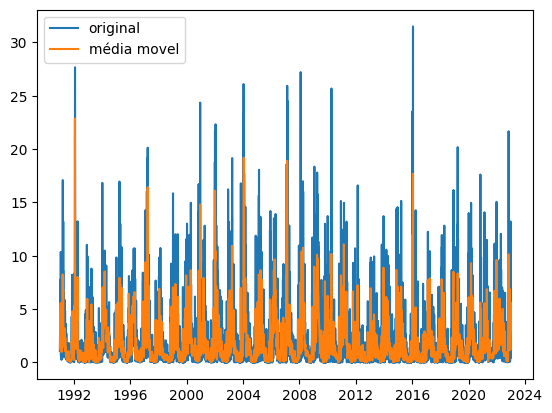

In [471]:
import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel2, label='média movel')
plt.legend()

## Soma cumulativa

<AxesSubplot:xlabel='Dia'>

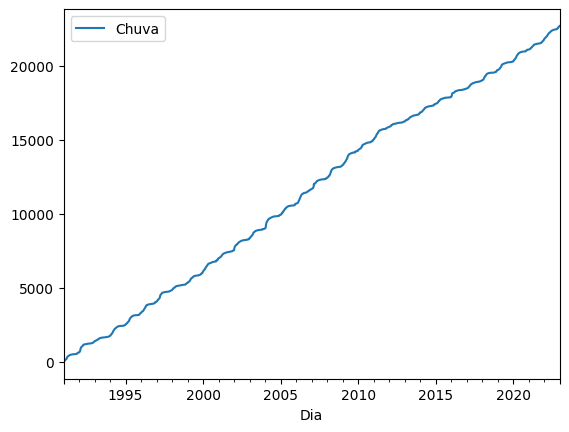

In [472]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html

soma_cumulativa = df1.cumsum()

soma_cumulativa.plot()

## Conta a quantidade de valores ausente da variável

In [473]:
df1.isnull().sum()

Chuva    1
dtype: int64

## Compartimentalização (binning)

In [474]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.cut.html

# Intervalos de interesse em mm/dia.
bins1 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

# Cria o histograma.
chuva1 = pd.cut(df1['Chuva'], bins1, right=False)

chuva1

Dia
1991-01-01    [0.0, 2.5)
1991-01-02    [0.0, 2.5)
1991-01-03    [0.0, 2.5)
1991-01-04    [0.0, 2.5)
1991-01-05    [0.0, 2.5)
                 ...    
2022-12-27    [0.0, 2.5)
2022-12-28    [0.0, 2.5)
2022-12-29    [0.0, 2.5)
2022-12-30    [0.0, 2.5)
2022-12-31    [0.0, 2.5)
Name: Chuva, Length: 11688, dtype: category
Categories (7, interval[float64, left]): [[0.0, 2.5) < [2.5, 7.6) < [7.6, 15.0) < [15.0, 30.0) < [30.0, 50.0) < [50.0, 75.0) < [75.0, 100.0)]

In [475]:
pd.value_counts(chuva1)

Chuva
[0.0, 2.5)       8837
[2.5, 7.6)       2268
[7.6, 15.0)       513
[15.0, 30.0)       68
[30.0, 50.0)        1
[50.0, 75.0)        0
[75.0, 100.0)       0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

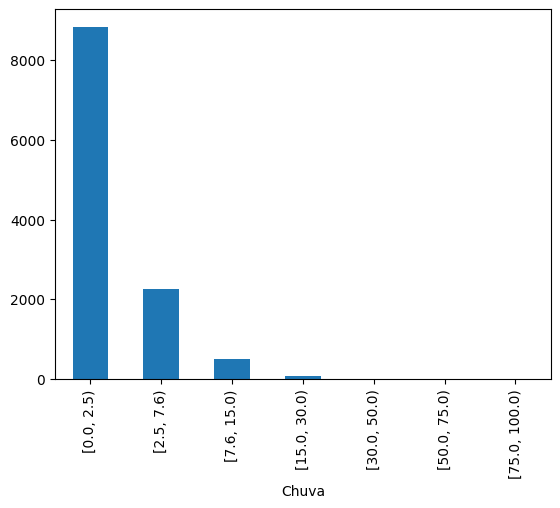

In [476]:
pd.value_counts(chuva1).plot.bar()

In [477]:
# Cria a coluna 'bin' no DataFrame 'df1' que receberá os valores de 'chuva1'.
df1['bin'] = chuva1

df1

,Chuva,bin
Dia,,
1991-01-01,1.083005,"[0.0, 2.5)"
1991-01-02,1.132334,"[0.0, 2.5)"
1991-01-03,1.101605,"[0.0, 2.5)"
1991-01-04,1.662441,"[0.0, 2.5)"
1991-01-05,1.765939,"[0.0, 2.5)"
...,...,...
2022-12-27,0.583862,"[0.0, 2.5)"
2022-12-28,0.579153,"[0.0, 2.5)"
2022-12-29,1.396807,"[0.0, 2.5)"


In [478]:
# Bins.
bins2 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

# Observação: A quantidade de rótulos (nome2) tem que ser uma unidade menor que a quantidade de classes (bins2).
# Exemplo: são utilizados 8 bins, logo a quantidade de rótulos deverá ser de 8-1=7 rótulos.

# Rótulos.
classificacao = ['Muito Fraca', 'Fraca', 'Moderada', 'Moderadamente Forte', 'Forte', 'Muito Forte', 'Extremamente Forte']

# Cria o histograma.
chuva2 = pd.cut(df1['Chuva'], bins2, labels=classificacao)

chuva2

Dia
1991-01-01    Muito Fraca
1991-01-02    Muito Fraca
1991-01-03    Muito Fraca
1991-01-04    Muito Fraca
1991-01-05    Muito Fraca
                 ...     
2022-12-27    Muito Fraca
2022-12-28    Muito Fraca
2022-12-29    Muito Fraca
2022-12-30    Muito Fraca
2022-12-31    Muito Fraca
Name: Chuva, Length: 11688, dtype: category
Categories (7, object): ['Muito Fraca' < 'Fraca' < 'Moderada' < 'Moderadamente Forte' < 'Forte' < 'Muito Forte' < 'Extremamente Forte']

In [479]:
# Contabiliza a quantidade de valores para cada rótulo (classificacao).
pd.value_counts(chuva2)

Chuva
Muito Fraca            8809
Fraca                  2268
Moderada                513
Moderadamente Forte      68
Forte                     1
Muito Forte               0
Extremamente Forte        0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

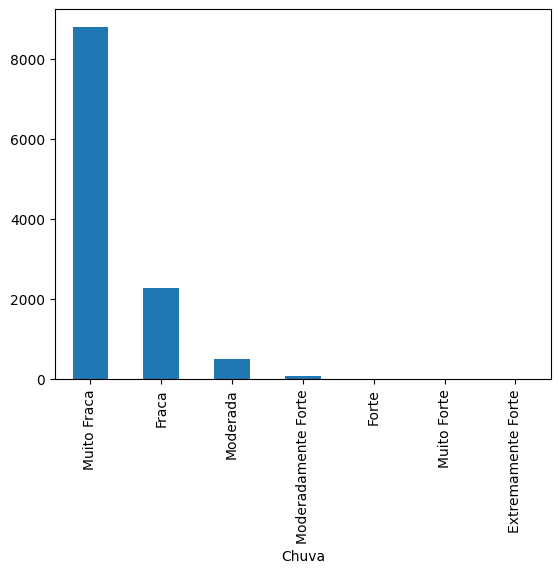

In [480]:
# Plot básico.
pd.value_counts(chuva2).plot.bar()

In [481]:
# Cria a coluna 'Classificacao' no DataFrame 'df1' que recebe o valor da variável chuva2.
df1['Classificacao'] = chuva2

In [482]:
df1

,Chuva,bin,Classificacao
Dia,,,
1991-01-01,1.083005,"[0.0, 2.5)",Muito Fraca
1991-01-02,1.132334,"[0.0, 2.5)",Muito Fraca
1991-01-03,1.101605,"[0.0, 2.5)",Muito Fraca
1991-01-04,1.662441,"[0.0, 2.5)",Muito Fraca
1991-01-05,1.765939,"[0.0, 2.5)",Muito Fraca
...,...,...,...
2022-12-27,0.583862,"[0.0, 2.5)",Muito Fraca
2022-12-28,0.579153,"[0.0, 2.5)",Muito Fraca
2022-12-29,1.396807,"[0.0, 2.5)",Muito Fraca


In [483]:
# Remove a coluna 'bin' do DataFrame.
df1.drop(columns=['bin', 'Classificacao'])

,Chuva
Dia,
1991-01-01,1.083005
1991-01-02,1.132334
1991-01-03,1.101605
1991-01-04,1.662441
1991-01-05,1.765939
...,...
2022-12-27,0.583862
2022-12-28,0.579153
2022-12-29,1.396807


## Meses mais chuvosos

In [484]:
df3

,Chuva
Mes,
1991-01,100.099648
1991-02,79.893944
1991-03,164.202332
1991-04,71.712448
1991-05,56.974304
...,...
2022-08,35.391964
2022-09,14.892078
2022-10,16.885502


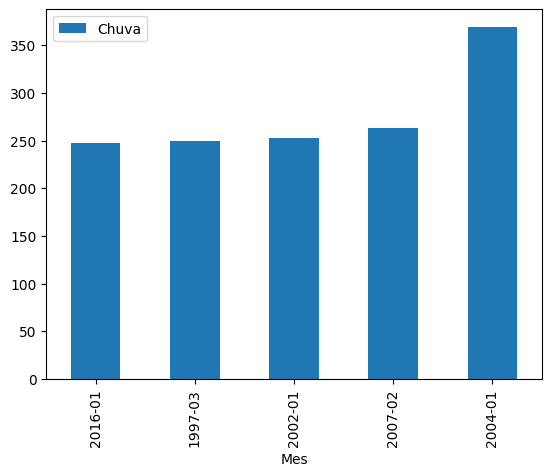

In [485]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html

# Os 5 meses mais chuvosos.
meses_mais_chuvoso = df3.nlargest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_mais_chuvoso.sort_values(by='Chuva').plot.bar()

## Meses menos chuvosos

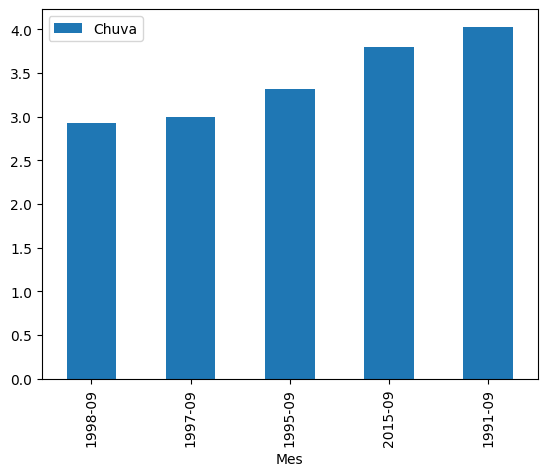

In [486]:
# Documentação
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nsmallest.html

# Os 5 meses menos chuvosos.
meses_menos_chuvoso = df3.nsmallest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_menos_chuvoso.sort_values(by='Chuva').plot.bar()

## Reshape

In [487]:
# Acumulado mensal.
chuva_acumulada1 = df2.resample('MS').sum()

# Remove o mês do rótulo da série temporal.
chuva_acumulada2 = chuva_acumulada1.resample('M', kind='period').sum()

# Renomeia o index para Mes.
chuva_acumulada2.index.name = 'Mes'

chuva_acumulada2

,Chuva
Mes,
1991-01,100.099648
1991-02,79.893944
1991-03,164.202332
1991-04,71.712448
1991-05,56.974304
...,...
2022-08,35.391964
2022-09,14.892078
2022-10,16.885502


In [488]:
# Uso do reshape para organizar o dado no formato vetor para o formato tabular (linhas x colunas).
dado_reshape = df3['Chuva'].values.reshape(32,12)

# Nome dos rótulos das colunas.
colunas = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Nome dos rótulos do index.
index = np.arange(1991, 2023)

# Cria o DataFrame.
df4 = pd.DataFrame(
    data=dado_reshape, 
    index=index, 
    columns=colunas
)

df4

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
1991,100.099648,79.893944,164.202332,71.712448,56.974304,26.477652,12.856383,14.162914,4.031318,5.157082,72.598381,40.504318
1992,219.365845,146.837051,89.832542,73.233086,11.459463,24.571976,21.251295,6.829010,13.757359,16.847679,45.421162,71.895309
1993,49.076027,54.951603,55.997139,48.910160,27.047003,14.300651,15.272163,7.003137,7.962822,21.911219,28.046429,36.357285
1994,113.659775,100.130547,176.621002,109.186760,62.264042,71.403969,30.487093,6.763389,8.827073,8.378450,28.984001,57.135120
1995,67.111679,110.128860,131.431259,148.319534,103.969421,29.755495,28.987825,6.343277,3.320884,15.852721,77.894936,80.272415
1996,75.620964,85.704758,147.965637,161.022720,53.885689,28.335045,16.862793,17.105371,7.448889,20.105776,93.265488,35.514210
1997,125.218681,65.670998,250.012924,116.590858,59.936180,15.083757,18.377230,11.314254,3.000110,32.169334,33.424679,54.426582
1998,110.865509,57.572250,74.942886,32.091286,17.635044,16.528275,16.960138,11.296473,2.924803,6.543128,74.763916,57.237045
1999,80.350380,85.277603,150.435410,55.227840,84.036903,17.328327,19.017815,17.067169,21.352268,39.673622,86.691559,120.673904
2000,109.138184,143.464432,110.721962,136.306122,39.746944,38.314617,33.246494,26.505228,25.393209,8.040903,89.847908,121.982460


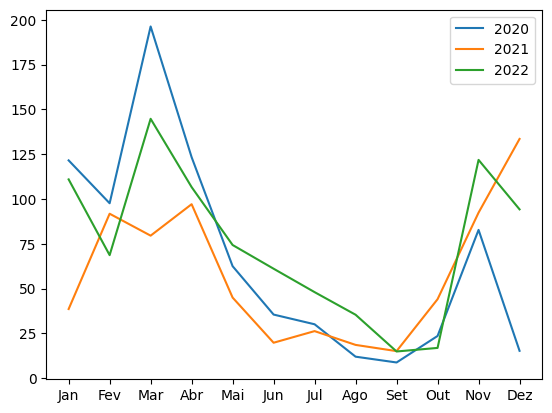

In [489]:
# Plot básico da chuva.
import matplotlib.pyplot as plt 

# Plot básico.
for ano in range(2020, 2023):
    plt.plot(df4.loc[ano,:], label=ano)
    plt.legend()

## Climatologia

In [490]:
# axis = 0 -> faz cálculo nas linhas.
# axis = 1 -> faz cálculo nas colunas.

climatologia = df4.loc[1991:2020].mean(axis=0)

climatologia

Jan    102.440216
Fev    101.429047
Mar    128.680374
Abr    101.024071
Mai     56.135792
Jun     33.991383
Jul     24.328671
Ago     14.224647
Set     11.540402
Out     21.283686
Nov     48.164700
Dez     60.147751
dtype: float32

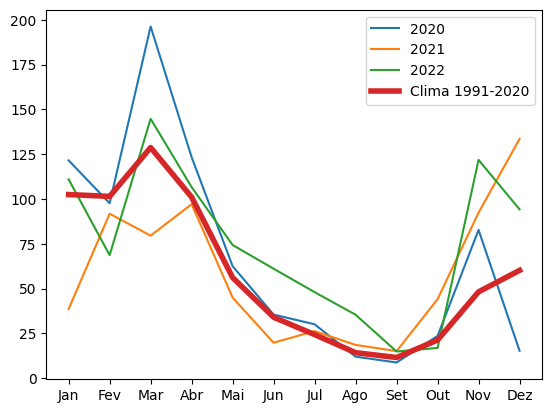

In [491]:
import matplotlib.pyplot as plt 

# Plot básico da chuva.
for ano in range(2020, 2023):
    plt.plot(df4.loc[ano,:], label=ano)

# Plot da climatologia.
plt.plot(climatologia, lw=4, label='Clima 1991-2020')

# Mostra a legenda no gráfico.
plt.legend()

## Anomalia

Anomalia = Valor observado - Climatologia

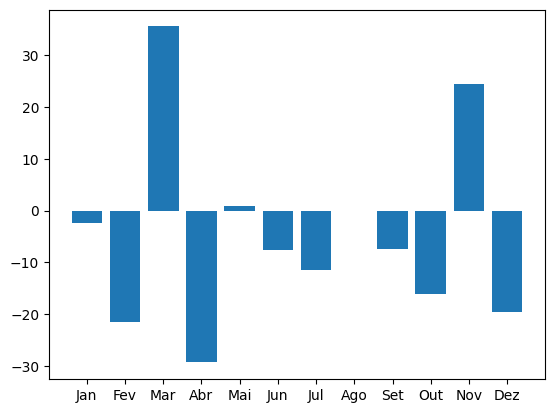

In [492]:
for ano in range(1991, 1992):
    anomalia = df4.loc[ano] - climatologia
    plt.bar(df4.columns, anomalia, label=ano)

## Acumulado anual

In [493]:
acumulado_anual = df4.sum(axis=1)

df4['Total'] = acumulado_anual

df4

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
1991,100.099648,79.893944,164.202332,71.712448,56.974304,26.477652,12.856383,14.162914,4.031318,5.157082,72.598381,40.504318,648.670776
1992,219.365845,146.837051,89.832542,73.233086,11.459463,24.571976,21.251295,6.829010,13.757359,16.847679,45.421162,71.895309,741.301758
1993,49.076027,54.951603,55.997139,48.910160,27.047003,14.300651,15.272163,7.003137,7.962822,21.911219,28.046429,36.357285,366.835632
1994,113.659775,100.130547,176.621002,109.186760,62.264042,71.403969,30.487093,6.763389,8.827073,8.378450,28.984001,57.135120,773.841309
1995,67.111679,110.128860,131.431259,148.319534,103.969421,29.755495,28.987825,6.343277,3.320884,15.852721,77.894936,80.272415,803.388306
1996,75.620964,85.704758,147.965637,161.022720,53.885689,28.335045,16.862793,17.105371,7.448889,20.105776,93.265488,35.514210,742.837341
1997,125.218681,65.670998,250.012924,116.590858,59.936180,15.083757,18.377230,11.314254,3.000110,32.169334,33.424679,54.426582,785.225586
1998,110.865509,57.572250,74.942886,32.091286,17.635044,16.528275,16.960138,11.296473,2.924803,6.543128,74.763916,57.237045,479.360718
1999,80.350380,85.277603,150.435410,55.227840,84.036903,17.328327,19.017815,17.067169,21.352268,39.673622,86.691559,120.673904,777.132874
2000,109.138184,143.464432,110.721962,136.306122,39.746944,38.314617,33.246494,26.505228,25.393209,8.040903,89.847908,121.982460,882.708435


In [494]:
# Valor médio anual de chuva;
media_anual = df4['Total'].mean()

media_anual

709.39526

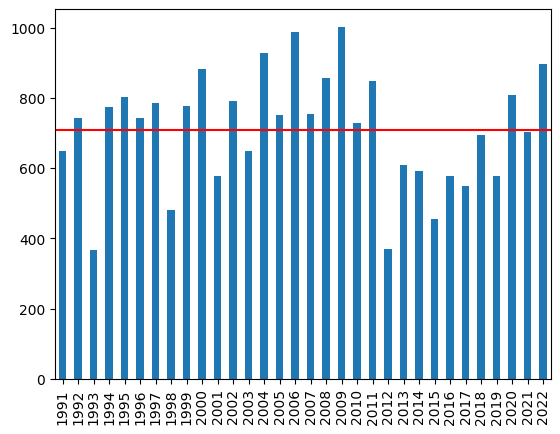

In [495]:
import matplotlib.pyplot as plt

# Plot básico de chuva.
df4['Total'].plot.bar()

# Plota uma linha horizontal no valor da média anual.
plt.axhline(y=media_anual, c='red')

## Anomalia anual

<AxesSubplot:>

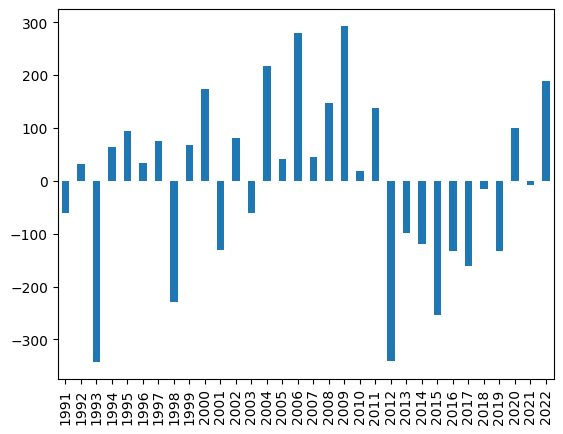

In [496]:
df4['Anom. Anual'] = df4['Total'] - media_anual

df4['Anom. Anual'].plot.bar()

## Aumento ou reduação percentual

Em relação à média anual, qual foi o aumento ou decremento percentual.

In [497]:
df4['Porcentagem'] = ((df4['Total'] / media_anual) * 100) - 100

df4

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total,Anom. Anual,Porcentagem
1991,100.099648,79.893944,164.202332,71.712448,56.974304,26.477652,12.856383,14.162914,4.031318,5.157082,72.598381,40.504318,648.670776,-60.724487,-8.560036
1992,219.365845,146.837051,89.832542,73.233086,11.459463,24.571976,21.251295,6.829010,13.757359,16.847679,45.421162,71.895309,741.301758,31.906494,4.497704
1993,49.076027,54.951603,55.997139,48.910160,27.047003,14.300651,15.272163,7.003137,7.962822,21.911219,28.046429,36.357285,366.835632,-342.559631,-48.288963
1994,113.659775,100.130547,176.621002,109.186760,62.264042,71.403969,30.487093,6.763389,8.827073,8.378450,28.984001,57.135120,773.841309,64.446045,9.084641
1995,67.111679,110.128860,131.431259,148.319534,103.969421,29.755495,28.987825,6.343277,3.320884,15.852721,77.894936,80.272415,803.388306,93.993042,13.249741
1996,75.620964,85.704758,147.965637,161.022720,53.885689,28.335045,16.862793,17.105371,7.448889,20.105776,93.265488,35.514210,742.837341,33.442078,4.714165
1997,125.218681,65.670998,250.012924,116.590858,59.936180,15.083757,18.377230,11.314254,3.000110,32.169334,33.424679,54.426582,785.225586,75.830322,10.689438
1998,110.865509,57.572250,74.942886,32.091286,17.635044,16.528275,16.960138,11.296473,2.924803,6.543128,74.763916,57.237045,479.360718,-230.034546,-32.426849
1999,80.350380,85.277603,150.435410,55.227840,84.036903,17.328327,19.017815,17.067169,21.352268,39.673622,86.691559,120.673904,777.132874,67.737610,9.548637
2000,109.138184,143.464432,110.721962,136.306122,39.746944,38.314617,33.246494,26.505228,25.393209,8.040903,89.847908,121.982460,882.708435,173.313171,24.431107


<AxesSubplot:>

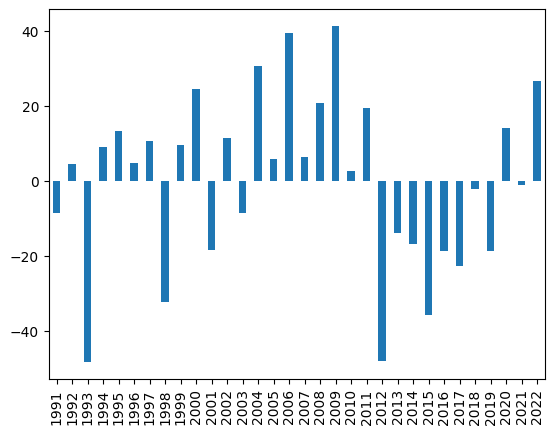

In [500]:
df4['Porcentagem'].plot.bar()

## Mudança (positivva ou negativa) percentual (%) de um ano para o ano seguinte

Qual é a porcentagem de mudança de um ano A para um ano B? A função **pct_change** faz este cálculo.

Exemplo:
- Chuva total em 1991: 648.670776
- Chuva total em 1992: 741.301758
- A mudança de 1991 para 1992 foi de: (741.301758 / 648.670776) x 100 = 114,2801226 - 100 = +14,280717%.

In [498]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html

df4['Change'] = df4['Total'].pct_change()*100.

df4

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total,Anom. Anual,Porcentagem,Change
1991,100.099648,79.893944,164.202332,71.712448,56.974304,26.477652,12.856383,14.162914,4.031318,5.157082,72.598381,40.504318,648.670776,-60.724487,-8.560036,NaN
1992,219.365845,146.837051,89.832542,73.233086,11.459463,24.571976,21.251295,6.829010,13.757359,16.847679,45.421162,71.895309,741.301758,31.906494,4.497704,14.280117
1993,49.076027,54.951603,55.997139,48.910160,27.047003,14.300651,15.272163,7.003137,7.962822,21.911219,28.046429,36.357285,366.835632,-342.559631,-48.288963,-50.514668
1994,113.659775,100.130547,176.621002,109.186760,62.264042,71.403969,30.487093,6.763389,8.827073,8.378450,28.984001,57.135120,773.841309,64.446045,9.084641,110.950424
1995,67.111679,110.128860,131.431259,148.319534,103.969421,29.755495,28.987825,6.343277,3.320884,15.852721,77.894936,80.272415,803.388306,93.993042,13.249741,3.818226
1996,75.620964,85.704758,147.965637,161.022720,53.885689,28.335045,16.862793,17.105371,7.448889,20.105776,93.265488,35.514210,742.837341,33.442078,4.714165,-7.536948
1997,125.218681,65.670998,250.012924,116.590858,59.936180,15.083757,18.377230,11.314254,3.000110,32.169334,33.424679,54.426582,785.225586,75.830322,10.689438,5.706263
1998,110.865509,57.572250,74.942886,32.091286,17.635044,16.528275,16.960138,11.296473,2.924803,6.543128,74.763916,57.237045,479.360718,-230.034546,-32.426849,-38.952480
1999,80.350380,85.277603,150.435410,55.227840,84.036903,17.328327,19.017815,17.067169,21.352268,39.673622,86.691559,120.673904,777.132874,67.737610,9.548637,62.118603
2000,109.138184,143.464432,110.721962,136.306122,39.746944,38.314617,33.246494,26.505228,25.393209,8.040903,89.847908,121.982460,882.708435,173.313171,24.431107,13.585270


<AxesSubplot:>

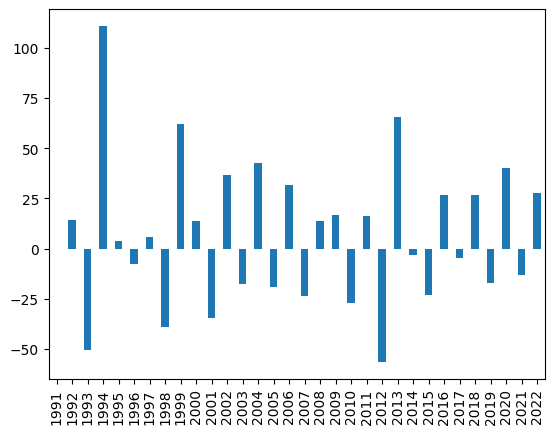

In [499]:
df4['Change'].plot.bar()

## Heatmap

In [502]:
import seaborn as sns

In [507]:
df5 = df4.iloc[:,0:12]

df5

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
1991,100.099648,79.893944,164.202332,71.712448,56.974304,26.477652,12.856383,14.162914,4.031318,5.157082,72.598381,40.504318
1992,219.365845,146.837051,89.832542,73.233086,11.459463,24.571976,21.251295,6.829010,13.757359,16.847679,45.421162,71.895309
1993,49.076027,54.951603,55.997139,48.910160,27.047003,14.300651,15.272163,7.003137,7.962822,21.911219,28.046429,36.357285
1994,113.659775,100.130547,176.621002,109.186760,62.264042,71.403969,30.487093,6.763389,8.827073,8.378450,28.984001,57.135120
1995,67.111679,110.128860,131.431259,148.319534,103.969421,29.755495,28.987825,6.343277,3.320884,15.852721,77.894936,80.272415
1996,75.620964,85.704758,147.965637,161.022720,53.885689,28.335045,16.862793,17.105371,7.448889,20.105776,93.265488,35.514210
1997,125.218681,65.670998,250.012924,116.590858,59.936180,15.083757,18.377230,11.314254,3.000110,32.169334,33.424679,54.426582
1998,110.865509,57.572250,74.942886,32.091286,17.635044,16.528275,16.960138,11.296473,2.924803,6.543128,74.763916,57.237045
1999,80.350380,85.277603,150.435410,55.227840,84.036903,17.328327,19.017815,17.067169,21.352268,39.673622,86.691559,120.673904
2000,109.138184,143.464432,110.721962,136.306122,39.746944,38.314617,33.246494,26.505228,25.393209,8.040903,89.847908,121.982460


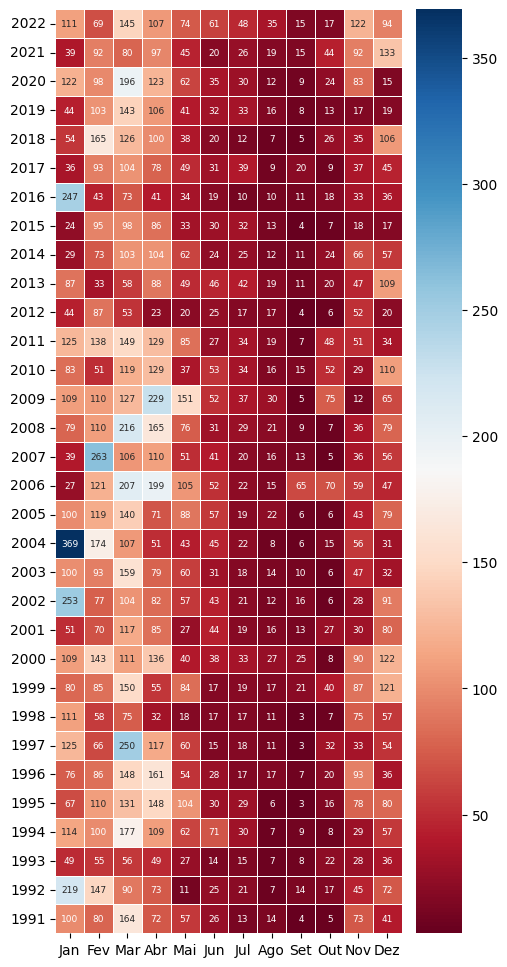

In [530]:
fig, ax = plt.subplots(figsize=(60, 12))
    
ax = sns.heatmap(df5, 
                 cmap='RdBu', 
                 linewidths=0.5, 
                 fmt='2.0f',
                 annot_kws={'size': 6.5},
                 cbar_kws={'orientation': 'vertical', 'shrink': 1, 'pad':0.003},  
                 annot=True, 
                 square=True
)

# Inverte o eixo y.
ax.invert_yaxis()